#**CSD458 HW5**
Classify Fashion MNist images using CNNs

In this notebook, we tackle the task of image classification using the Fashion MNIST dataset, a collection of apparel images commonly used for training machine learning models. Our approach involves developing our own models with a custom architecture designed to efficiently classify these images. Throughout the notebook, we will train these models from scratch, monitor their performance, and compare the outcomes. We also plan to dive into the models' internals by visualizing some of the feature maps generated during the training process. This will give us insights into how our models are interpreting the apparel images. Towards the end, we shift gears to apply transfer learning, leveraging a pre-trained model to see how it stacks up against our custom-built solutions. This step-by-step process will not only highlight the effectiveness of our CNN architecture but also demonstrate the power of transfer learning in the context of image classification.

In [17]:
# Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
import pandas as pd
from torch.optim import lr_scheduler
import copy
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np



### **PART A: Training Convolutional Neural Networks (CNNs)**



#### 1. Download the Fashion Mnist Dataset



In [2]:
# Define the transformation to convert PIL images to tensors
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Load the complete dataset for training (with transforms) and test
full_train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Split the full training dataset into training and validation sets
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

#### 2. Define the Dataset, Dataloader, Transforms. Use v2.Compose() to include even more transforms, such as rotations, crops and others.



In [3]:
# Define dataloaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=3)

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### 3. Make your own version of CNN and report the validatation set accuracy



 Our architecture draws inspiration from the depth-focused principles of VGG, integrating modern enhancements to streamline the model. Beginning with an adaptable initial convolution layer, the network dynamically constructs composite layers, each designed to double feature channels and preserve spatial dimensions through strategic convolutions, ReLU activations, and batch normalization, with optional pooling that halves our spacial dimensions. The model culminates in a dropout layer for regularization, leading to a global average pooling layer, and a fully connected output layer, all initialized using Xavier's approach for optimal weight distribution.

First, let us define the functions used to create our parametrized CNN models.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def create_layer(in_channels, out_channels, kernel_size=3, stride=1, padding=1, pool_kernel_size=2, pool_stride=2, include_pooling=True):
    """
    Creates a layer consisting of two convolutional blocks followed by a max pooling operation.
    Each block consists of a Convolution -> ReLU sequence. This is followed by Batch Normalization and Max Pooling.
    """
    layer = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.ReLU()
    )
    
    if include_pooling:
        layer.add_module('MaxPool', nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride))
        layer.add_module('BatchNorm', nn.BatchNorm2d(out_channels))
    
    return layer

class ParametrizedCNN(nn.Module):
    def __init__(self, in_channels, first_out_channels, n_layers=2):
        super(ParametrizedCNN, self).__init__()

        # Initial in_channels is 1 for grayscale images
        self.initial_in_channels = in_channels
        self.initial_out_channels = first_out_channels
        self.n_layers = n_layers

        # Create the layers
        self.layers = nn.ModuleList([create_layer(self.initial_in_channels, self.initial_out_channels)])
        for i in range(1, n_layers):
            if i == n_layers - 1:
                self.layers.append(create_layer(self.initial_out_channels * (2 ** (i - 1)), self.initial_out_channels * (2 ** i), include_pooling=False))
            else:
                self.layers.append(create_layer(self.initial_out_channels * (2 ** (i - 1)), self.initial_out_channels * (2 ** i)))
        
        self.fc1 = nn.Linear(self.initial_out_channels * (2 ** (self.n_layers - 1)), 10)  # Assuming final output has 10 classes

    def forward(self, x):

        # Apply the layers
        for layer in self.layers:
            x = layer(x)
            
        # apply dropout
        x = F.dropout(x, p=0.5)
        
        # Apply Global Average Pooling, instead of flattening and big fully connected layers
        x = F.adaptive_avg_pool2d(x, (1, 1))
        
        x = x.view(-1, self.initial_out_channels * (2 ** (self.n_layers - 1)))  # Flatten for the fully connected layer;

        x = self.fc1(x)

        # Return log softmax of the output
        return F.log_softmax(x, dim=1)


Let's also define some utility functions to help us train the models and visualize the results.

In [77]:
from tqdm import tqdm
import csv
import copy

def train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, device, num_epochs = 10, writer=None, config_description=None):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epoch_bar = tqdm(range(num_epochs), desc='Epochs', position=0, leave=True)
    for epoch in range(num_epochs):


        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = valid_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            epoch_bar.set_postfix({'Phase': phase, 'Epoch': epoch+1, 'Loss': epoch_loss, 'Accuracy': epoch_acc.item()})

            if writer is not None:
                writer.writerow([config_description, phase, epoch+1, epoch_loss, epoch_acc.item()])

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
        epoch_bar.update(1)

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [78]:
def train_multiple_models(configurations, train_loader, val_loader, device, results_filename=None, fields=None, overwrite=True):

    writer = None
    if results_filename is not None:
        if overwrite:
            file = open(results_filename, mode='w', newline='')
            writer = csv.writer(file)
            writer.writerow(fields)  # Write the header
        else:
            file = open(results_filename, mode='a', newline='')
            writer = csv.writer(file)

    best_models = []
    for config in configurations:
        # Create model, optimizer, scheduler, and criterion using functions from config
        model = config['model_fn']().to(device)
        # TODO INITIALIZE_WEIGHTS FUNCTION SHOULD NOT BE CALLED FROM THIS GENERIC ONE
        #       must be taken care off, must take as input and carray a default case
        model.apply(initialize_weights)  # Assuming initialize_weights is defined elsewhere
        optimizer = config['optimizer_fn'](model.parameters())
        scheduler = config['scheduler_fn'](optimizer)
        criterion = config['criterion_fn']()

        # Train the model with the current configuration
        best_config_model = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, device, config['num_epochs'], writer, config['config_description'])

        best_models.append(best_config_model)

    # Close file if it was opened
    if results_filename is not None:
        file.close()

    return best_models

In [4]:
from matplotlib import pyplot as plt

def plot_results(df):
    # Set up the matplotlib figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharex=True)
    
    # Separate the configurations to plot them individually for clarity
    config_groups = df.groupby('Configuration')
    
    # Loss plot
    for config, group in config_groups:
        train_group = group[group['Phase'] == 'train']
        val_group = group[group['Phase'] == 'val']
        # Solid line for training
        ax1.plot(train_group['Epoch'], train_group['Loss'], label=f'{config} Train', linestyle=':')
        # Dotted line for validation
        ax1.plot(val_group['Epoch'], val_group['Loss'], label=f'{config} Validation')
    
    # Accuracy plot
    for config, group in config_groups:
        train_group = group[group['Phase'] == 'train']
        val_group = group[group['Phase'] == 'val']
        # Solid line for training
        ax2.plot(train_group['Epoch'], train_group['Accuracy'], label=f'{config} Train', linestyle=':')
        # Dotted line for validation
        ax2.plot(val_group['Epoch'], val_group['Accuracy'], label=f'{config} Validation')
    
    # Titles and labels
    ax1.set_title('Training and Validation Loss by Configuration')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    
    ax2.set_title('Training and Validation Accuracy by Configuration')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='lower right')
    
    # Show plot
    plt.tight_layout()
    plt.show()
    

Let's now begin by training our small models, with 2 and 3 layers, and 32 and 16 filters, respectively. We will use the Adam optimizer with a learning rate of 0.001, and a step scheduler that reduces the learning rate by half every 7 epochs. We will train the models for 20 epochs and log the results to a CSV file.

In [31]:
results_filename = "results_small_.csv"
fields = ['Configuration', 'Phase', 'Epoch', 'Loss', 'Accuracy']

configurations = [
    {
        'model_fn': lambda: ParametrizedCNN(1, 32, 2),
        'optimizer_fn': lambda params: optim.Adam(params, lr=0.001),
        'scheduler_fn': lambda optimizer: lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5),
        'criterion_fn': lambda: nn.CrossEntropyLoss(),
        'num_epochs': 20,
        'config_description': '32x2_0.001',
    },
    {
        'model_fn': lambda: ParametrizedCNN(1, 16, 3),
        'optimizer_fn': lambda params: optim.Adam(params, lr=0.001),
        'scheduler_fn': lambda optimizer: lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5),
        'criterion_fn': lambda: nn.CrossEntropyLoss(),
        'num_epochs': 20,
        'config_description': '16x3_0.001',
    }
]

best_models = train_multiple_models(configurations, train_loader, val_loader, device, results_filename=results_filename, fields=fields)

Epochs: 100%|██████████| 20/20 [25:27<00:00, 76.38s/it]


Best val Acc: 0.919167


Epochs: 100%|██████████| 20/20 [18:05<00:00, 54.28s/it]

Best val Acc: 0.920167


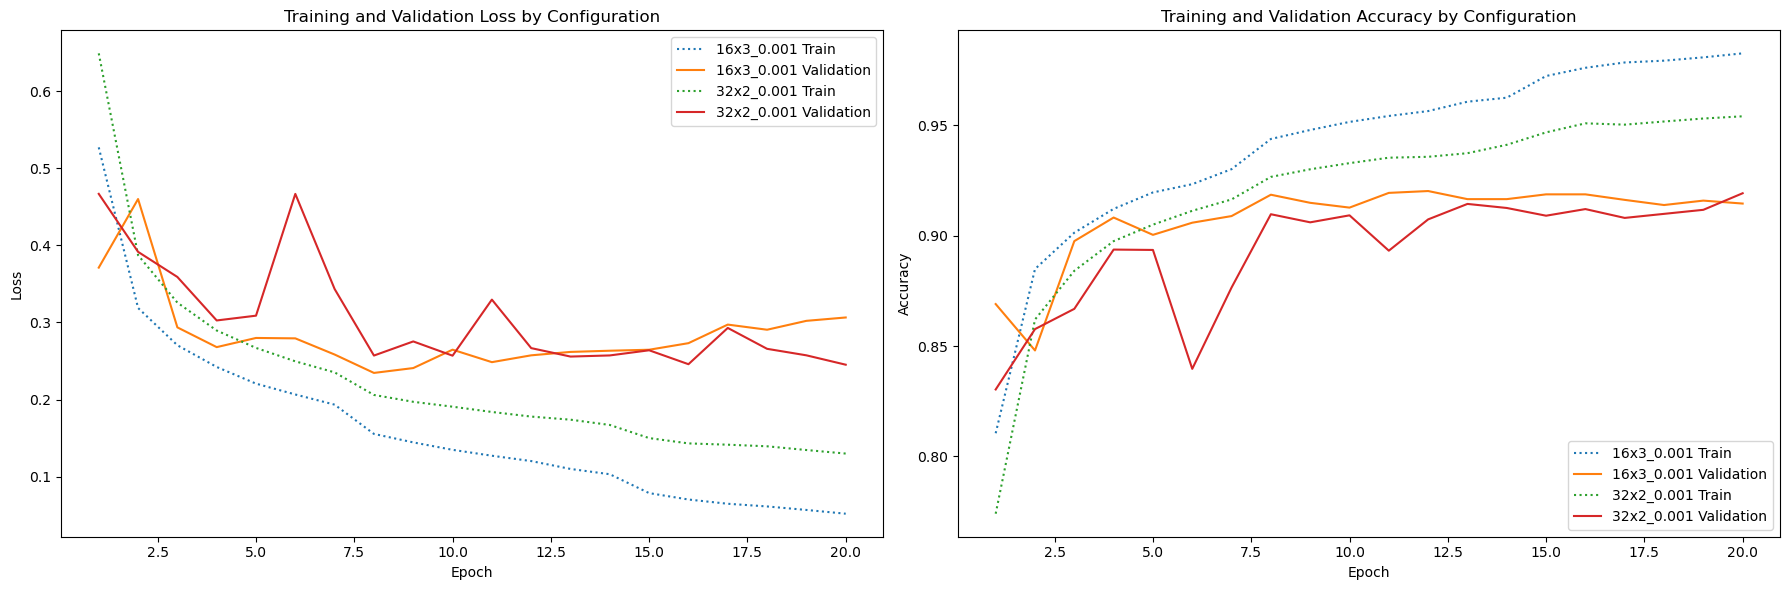

In [5]:
df = pd.read_csv('results/results_small.csv')

plot_results(df)

We observe signs of overfitting, as after epoch 7, the training loss keeps decreasing, while the test loss starts increasing. Looks like the dropout layer we added at the end was not enough.

Also notice the scheduler's effect on the loss and accuracy during the training process. At epochs 7 and 15, we observe these clear "steps" that our lines have due to the change of the learning rate. This is a common technique to help the model converge better, by reducing the learning rate as the model gets closer to the optimal solution.

Let's try data augmentation and L2 Regularization to see if we can improve the model's performance, by introducing variance to the training samples, thus in theory training a model that will be able to generalize to unseen data better.

We will also train a bigger network, in hopes of achieving better results.

In [79]:
from torchvision.transforms import v2

# Define the transformation to convert PIL images to tensors
transform = v2.Compose([
    v2.RandomResizedCrop(28, scale=(0.8, 1.0)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),
    v2.Normalize((0.5,), (0.5,))
])

# Load the complete dataset for training (with transforms) and test
full_train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform)

# Split the full training dataset into training and validation sets (e.g., 90/10 split)
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Define dataloaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=3)

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
results_filename = "results_medium_.csv"
fields = ['Configuration', 'Phase', 'Epoch', 'Loss', 'Accuracy']

configurations = [
    {
        'model_fn': lambda: ParametrizedCNN(1, 64, 2),
        'optimizer_fn': lambda params: optim.Adam(params, lr=0.001, weight_decay=1e-5),
        'scheduler_fn': lambda optimizer: lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5),
        'criterion_fn': lambda: nn.CrossEntropyLoss(),
        'num_epochs': 20,
        'config_description': '64x2_0.001',
    },
    {
        'model_fn': lambda: ParametrizedCNN(1, 32, 3),
        'optimizer_fn': lambda params: optim.Adam(params, lr=0.001, weight_decay=1e-5),
        'scheduler_fn': lambda optimizer: lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5),
        'criterion_fn': lambda: nn.CrossEntropyLoss(),
        'num_epochs': 20,
        'config_description': '32x3_0.001',
    }
]

best_models = train_multiple_models(configurations, train_loader, val_loader, device, results_filename=results_filename, fields=fields)

Epochs: 100%|██████████| 20/20 [50:54<00:00, 152.71s/it, Phase=val, Epoch=20, Loss=0.225, Accuracy=0.919]  


Best val Acc: 0.921833


Epochs: 100%|██████████| 20/20 [30:04<00:00, 90.21s/it, Phase=val, Epoch=20, Loss=0.208, Accuracy=0.926]  

Best val Acc: 0.927333


In [28]:
torch.save(best_models[0].state_dict(), 'models/model_64x2.pth')
torch.save(best_models[1].state_dict(), 'models/model_32x3.pth')

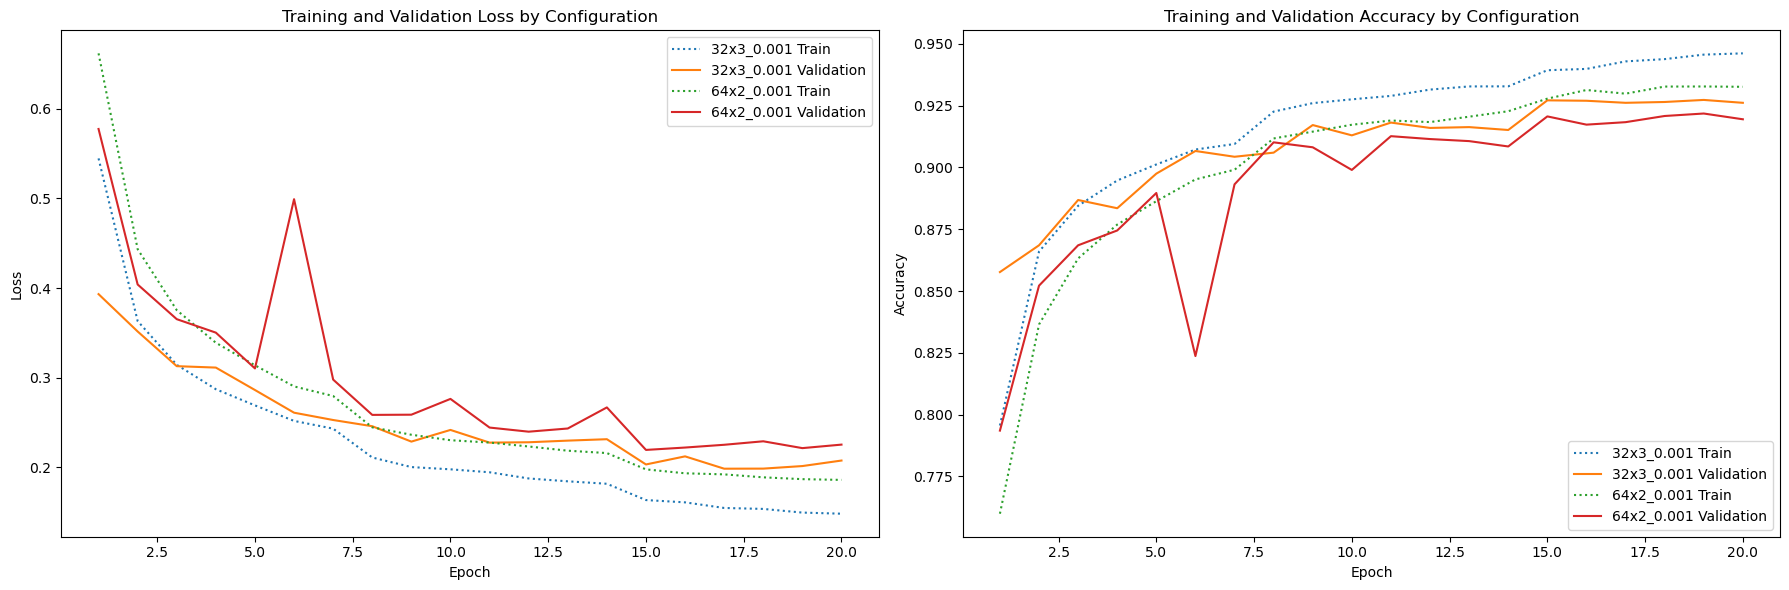

In [6]:
df = pd.read_csv('results/results_medium.csv')

plot_results(df)

Thanks to the introduced variance of the training set, and the small L2 penalty, we managed to reduce the overfitting of the model. The training and validation losses are now closer to each other, and the model's accuracy is higher.

Looks like the reason we dont see a higher accuracy is because the model is not complex enough to capture the variance of the data. We will now train a bigger model to see if we can achieve better results.

#### 5. Increase the number of Layers of the CNN (the number of convolutions followed by pooling layers) and observe what happens, in terms of the progress of the training and validation losses and the final model accuracies.

We will now train the last 2 and biggest models, with 64 filters and 3 layers, and 32 filters and 4 layers, to see how they perform.

In [31]:
results_filename = "results_large_.csv"
fields = ['Configuration', 'Phase', 'Epoch', 'Loss', 'Accuracy']

configurations = [
    {
        'model_fn': lambda: ParametrizedCNN(1, 64, 3),
        'optimizer_fn': lambda params: optim.Adam(params, lr=0.001, weight_decay=1e-5),
        'scheduler_fn': lambda optimizer: lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5),
        'criterion_fn': lambda: nn.CrossEntropyLoss(),
        'num_epochs': 25,
        'config_description': '64x3_0.001',
    },
    {
        'model_fn': lambda: ParametrizedCNN(1, 32, 4),
        'optimizer_fn': lambda params: optim.Adam(params, lr=0.001, weight_decay=1e-5),
        'scheduler_fn': lambda optimizer: lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5),
        'criterion_fn': lambda: nn.CrossEntropyLoss(),
        'num_epochs': 25,
        'config_description': '32x4_0.001',
    }
]
best_models = train_multiple_models(configurations, train_loader, val_loader, device, results_filename=results_filename, fields=fields)

Epochs: 100%|██████████| 25/25 [1:32:38<00:00, 222.35s/it, Phase=val, Epoch=25, Loss=0.187, Accuracy=0.938]   


Best val Acc: 0.940000


Epochs: 100%|██████████| 25/25 [46:43<00:00, 112.14s/it, Phase=val, Epoch=25, Loss=0.203, Accuracy=0.936]   

Best val Acc: 0.935833


In [32]:
torch.save(best_models[0].state_dict(), 'models/model_64x3.pth')
torch.save(best_models[1].state_dict(), 'models/model_32x4.pth')

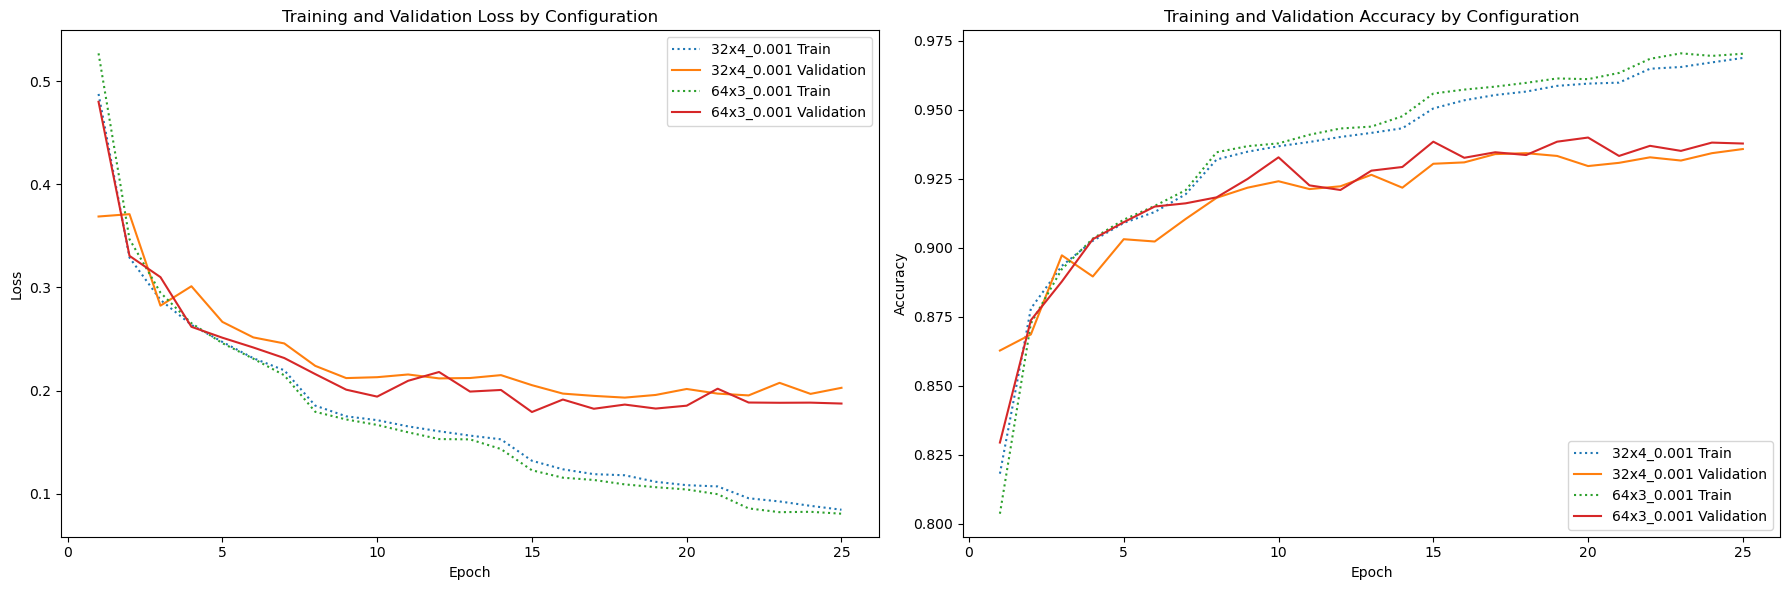

In [7]:
df = pd.read_csv('results/results_large.csv')

plot_results(df)

Because we increased the model's capacity, we observe that the model is able to fit the training data better, as the training loss is lower than before. However, the validation loss is higher, which is a sign of overfitting. The model is not able to generalize well to unseen data, as the accuracy is not as high as we would like.

Let's increase the regularization to see if we can improve the model's performance.

In [84]:
results_filename = "results_large_regul_.csv"
fields = ['Configuration', 'Phase', 'Epoch', 'Loss', 'Accuracy']

configurations = [
    {
        'model_fn': lambda: ParametrizedCNN(1, 64, 3),
        'optimizer_fn': lambda params: optim.Adam(params, lr=0.001, weight_decay=5e-3),
        'scheduler_fn': lambda optimizer: lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5),
        'criterion_fn': lambda: nn.CrossEntropyLoss(),
        'num_epochs': 50,
        'config_description': '64x3_5e-3',
    },
    {
        'model_fn': lambda: ParametrizedCNN(1, 32, 4),
        'optimizer_fn': lambda params: optim.Adam(params, lr=0.001, weight_decay=5e-3),
        'scheduler_fn': lambda optimizer: lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5),
        'criterion_fn': lambda: nn.CrossEntropyLoss(),
        'num_epochs': 50,
        'config_description': '32x4_5e-3',
    },
    {
        'model_fn': lambda: ParametrizedCNN(1, 64, 3),
        'optimizer_fn': lambda params: optim.Adam(params, lr=0.001, weight_decay=1e-2),
        'scheduler_fn': lambda optimizer: lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5),
        'criterion_fn': lambda: nn.CrossEntropyLoss(),
        'num_epochs': 50,
        'config_description': '64x3_1e-2',
    },
    {
        'model_fn': lambda: ParametrizedCNN(1, 32, 4),
        'optimizer_fn': lambda params: optim.Adam(params, lr=0.001, weight_decay=1e-2),
        'scheduler_fn': lambda optimizer: lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5),
        'criterion_fn': lambda: nn.CrossEntropyLoss(),
        'num_epochs': 50,
        'config_description': '32x4_1e-2',
    }
]
best_models = train_multiple_models(configurations, train_loader, val_loader, device, results_filename=results_filename, fields=fields)

Epochs: 100%|██████████| 50/50 [3:04:10<00:00, 221.02s/it, Phase=val, Epoch=50, Loss=0.188, Accuracy=0.934]    


Best val Acc: 0.935333


Epochs: 100%|██████████| 50/50 [1:34:46<00:00, 113.73s/it, Phase=val, Epoch=50, Loss=0.185, Accuracy=0.935]  


Best val Acc: 0.938333


Epochs: 100%|██████████| 50/50 [2:55:58<00:00, 211.17s/it, Phase=val, Epoch=50, Loss=0.2, Accuracy=0.933]      


Best val Acc: 0.935333


Epochs: 100%|██████████| 50/50 [1:28:51<00:00, 106.63s/it, Phase=val, Epoch=50, Loss=0.193, Accuracy=0.933]  

Best val Acc: 0.938000


In [89]:
# save both models
for i, model in enumerate(best_models):
    torch.save(model.state_dict(), f'models/model_{configurations[i]["config_description"]}.pth')

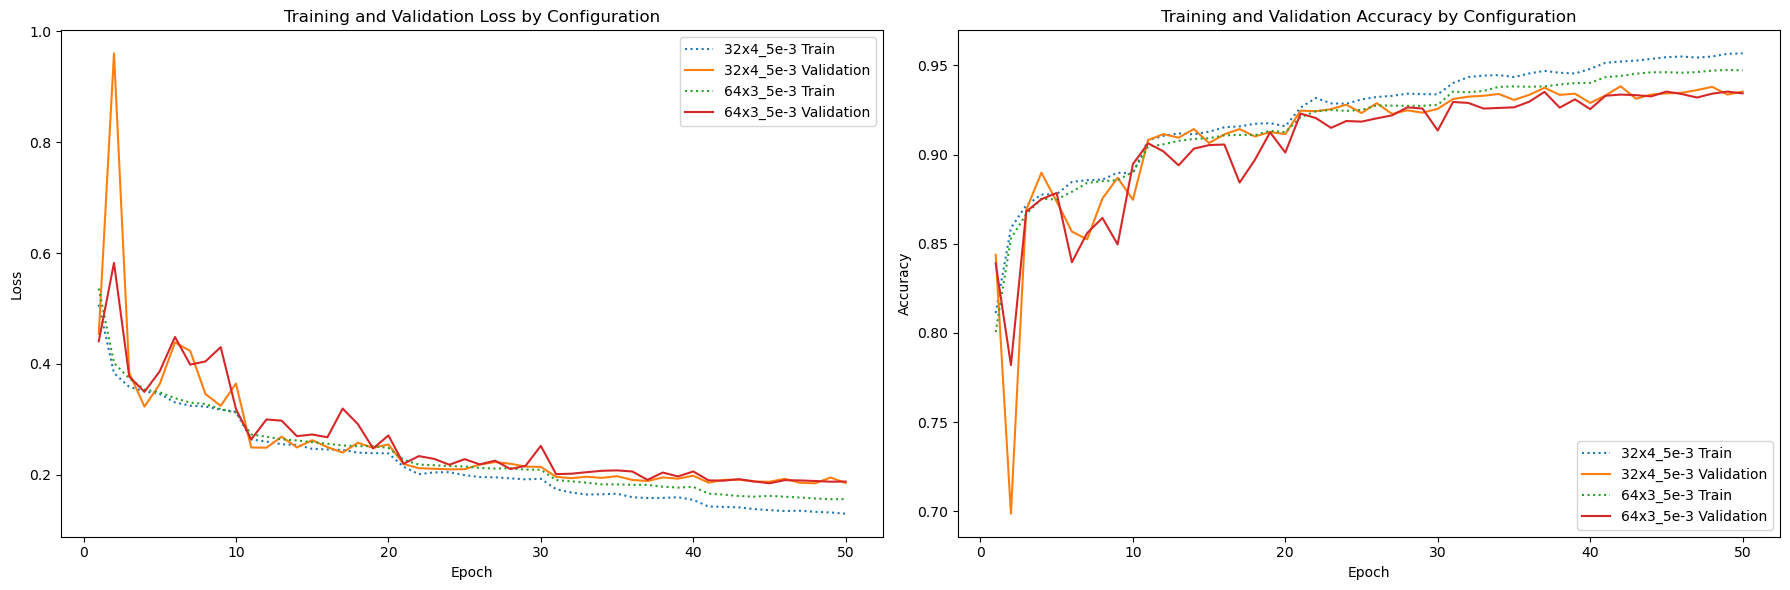

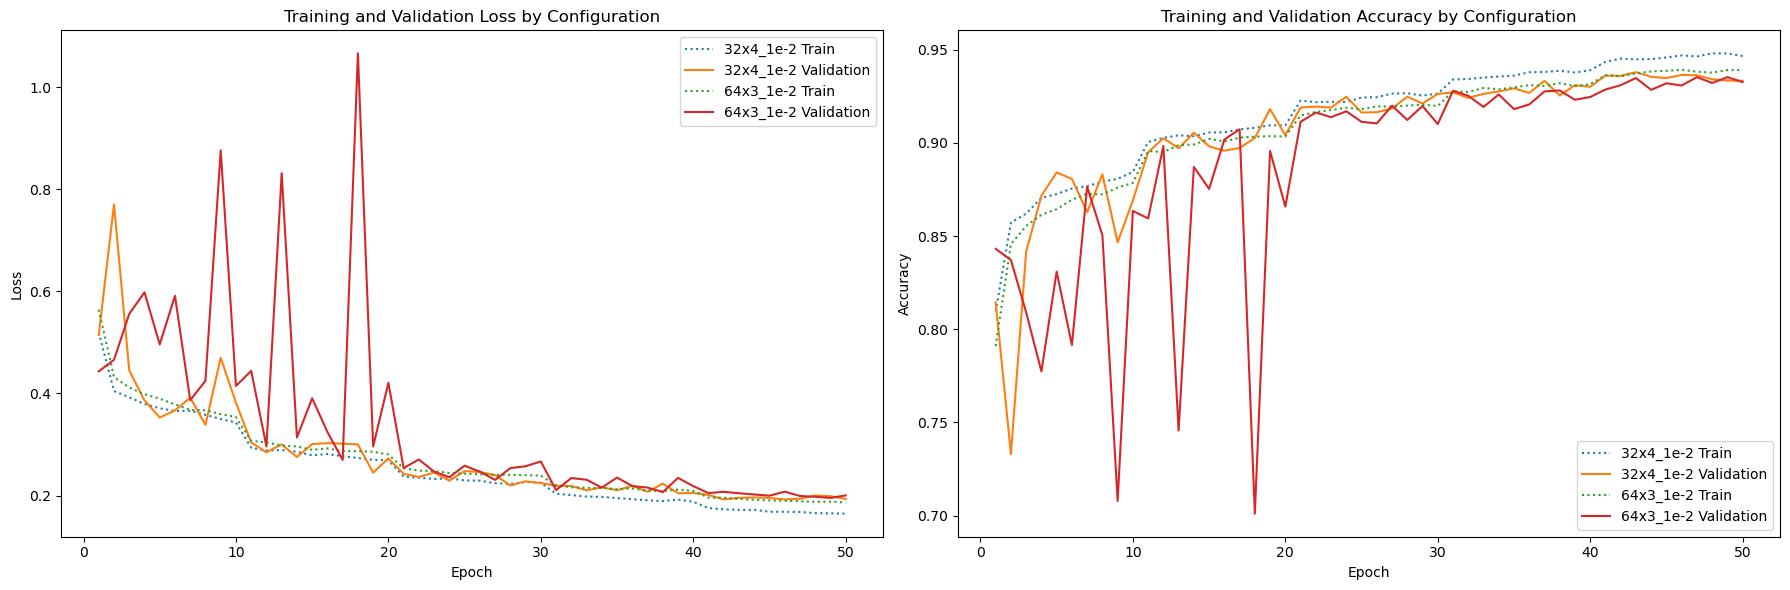

In [8]:
df = pd.read_csv('results/results_large_regul.csv')

df1 = df.iloc[:200]
df2 = df.iloc[200:]

plot_results(df1)
plot_results(df2)

Due to the increase of the regularization, we managed to reduce the overfitting of the model. The training and validation losses are now closer to each other, but the models' accuracy did not improve, even after running for 50 epochs. Further investigation is needed to understand the cap of the proposed models' performance. 

One area of interest, would be to increase the convolution layers in each composite layer, before max pooling, to see if we can achieve better results. This would in theory increase the receptive field of the model, which may be especially useful for the Fashion MNIST dataset, as the images are small and the features are not as clear as in other datasets. Trying something like a big 7x7 convolution layer, or a series of 3x3 convolution layers, could help the model capture more complex features earlier on, where the images retain most of their size. Deeper composite layers, can also be used in the later stages of the model with a bottleneck structure, to reduce the number of parameters and increase the model's capacity.

Another thing that should be investigated, is the expressive power of using global average pooling instead of flattening the output of the final convolutional layer and using a big fully connected layer. This is a common technique used in modern large scale models, which significantly reduces the number of trainable parameters. The case could be made that for our smaller models, it may be more beneficial to use a big fully connected layer, as the model may not be able to capture the complexity of the data with the global average pooling layer.

Finally, we could try to use a bigger model, with more layers and more filters, to see if we can achieve better results, paired with more advanced data augmentations and/or dropout layers. This would be a more computationally expensive approach, but it could help us understand the limits of the proposed models' performance.

Let's score the best models we trained so far, to see how they perform on the test set.

In [11]:
# Load the best models
model_16x3 = ParametrizedCNN(1, 16, 3)
model_16x3.load_state_dict(torch.load('models/model_16x3.pth'))

model_32x3 = ParametrizedCNN(1, 32, 3)
model_32x3.load_state_dict(torch.load('models/model_32x3.pth'))

model_64x3 = ParametrizedCNN(1, 64, 3)
model_64x3.load_state_dict(torch.load('models/model_64x3.pth'))

model_32x4 = ParametrizedCNN(1, 32, 4)
model_32x4.load_state_dict(torch.load('models/model_32x4.pth'))

# regularized models
model_64x3_5e3 = ParametrizedCNN(1, 64, 3)
model_64x3_5e3.load_state_dict(torch.load('models/model_64x3_5e-3.pth'))

model_32x4_5e3 = ParametrizedCNN(1, 32, 4)
model_32x4_5e3.load_state_dict(torch.load('models/model_32x4_5e-3.pth'))

model_64x3_1e2 = ParametrizedCNN(1, 64, 3)
model_64x3_1e2.load_state_dict(torch.load('models/model_64x3_1e-2.pth'))

model_32x4_1e2 = ParametrizedCNN(1, 32, 4)
model_32x4_1e2.load_state_dict(torch.load('models/model_32x4_1e-2.pth'))


<All keys matched successfully>

In [14]:
# load the test dataset
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=test_transform)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
# Test the models
models = [model_16x3, model_32x3, model_64x3, model_32x4, model_64x3_5e3, model_32x4_5e3, model_64x3_1e2, model_32x4_1e2]
model_names = ['16x3', '32x3', '64x3', '32x4', '64x3_5e3', '32x4_5e3', '64x3_1e2', '32x4_1e2']

accuracies = []
for model, name in zip(models, model_names):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    accuracy = 100 * correct / total
    print(f'Accuracy of the {name} model on the test images: {accuracy:.2f}%')
    accuracies.append(accuracy)

Accuracy of the 16x3 model on the test images: 91.21%
Accuracy of the 32x3 model on the test images: 93.04%
Accuracy of the 64x3 model on the test images: 94.09%
Accuracy of the 32x4 model on the test images: 94.08%
Accuracy of the 64x3_5e3 model on the test images: 93.08%
Accuracy of the 32x4_5e3 model on the test images: 93.55%
Accuracy of the 64x3_1e2 model on the test images: 92.79%
Accuracy of the 32x4_1e2 model on the test images: 93.33%


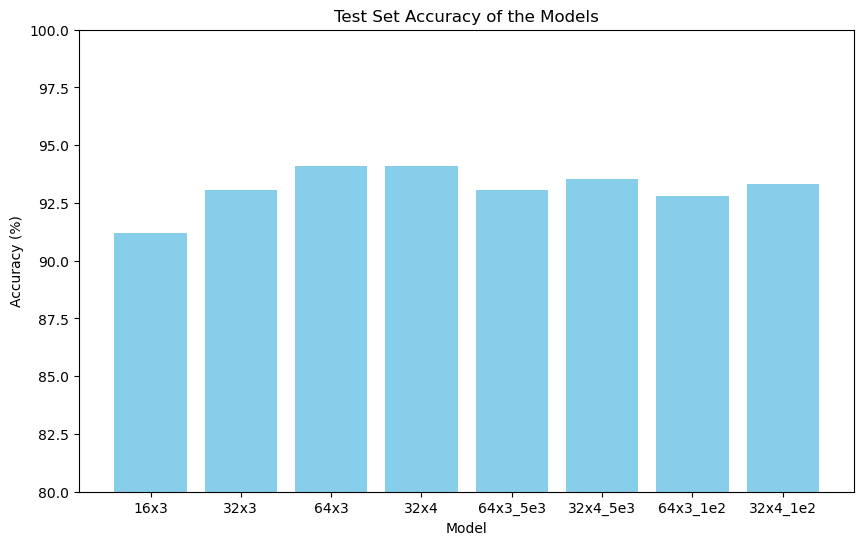

In [26]:
# bar plot of the accuracies
plt.figure(figsize=(10, 6))

plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Test Set Accuracy of the Models')
plt.ylim(80, 100)

plt.show()

In [27]:
# confusion matrix
# Get the predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_64x3(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

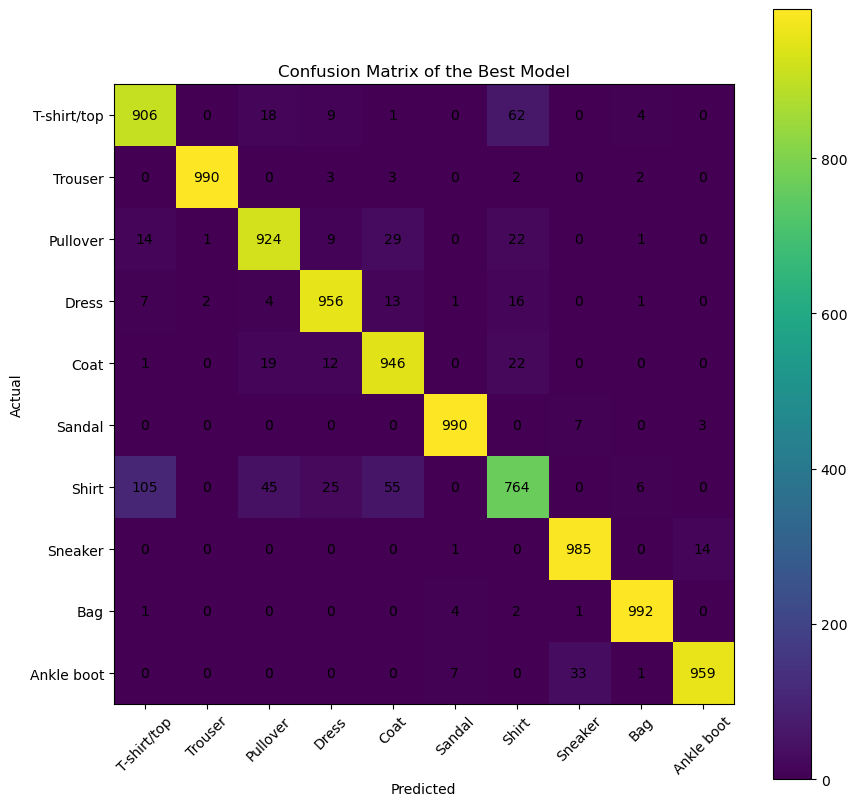

In [28]:
# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, cmap='viridis')
plt.colorbar()

# include label names
plt.xticks(np.arange(10), ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45)
plt.yticks(np.arange(10), ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

# have the values in each cell
for i in range(10):
    for j in range(10):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of the Best Model')

plt.show()

We observe the confusion matrix of the best performing model, 64x3 with a small regularization of 1e-5. The model is able to classify the images with high accuracy, with the most troublesome class being the Shirt class, which is often confused with T-shirt/top, Pullover and Coat. 

#### 6. Visualize some of the Feature Maps and Convolution Kernels that you find interesting.

In [21]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model_64x3.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.ModuleList:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    
print(f"Total convolution layers: {counter}")
print(conv_layers)

Total convolution layers: 6
[Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]


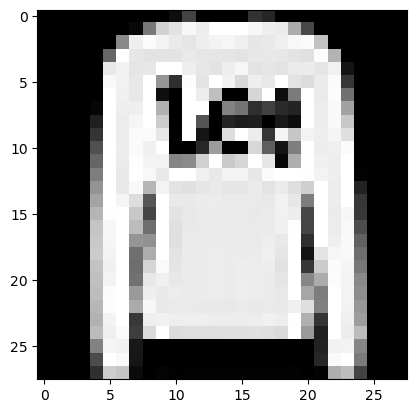

In [22]:
inputs, classes = next(iter(test_loader))

img = inputs[1]

img_np = np.asarray(img)

img_np_squeezed = img_np.squeeze() 

plt.imshow(img_np_squeezed, cmap='gray')
plt.show()

In [23]:
image = img.to(device)

outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))

processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())

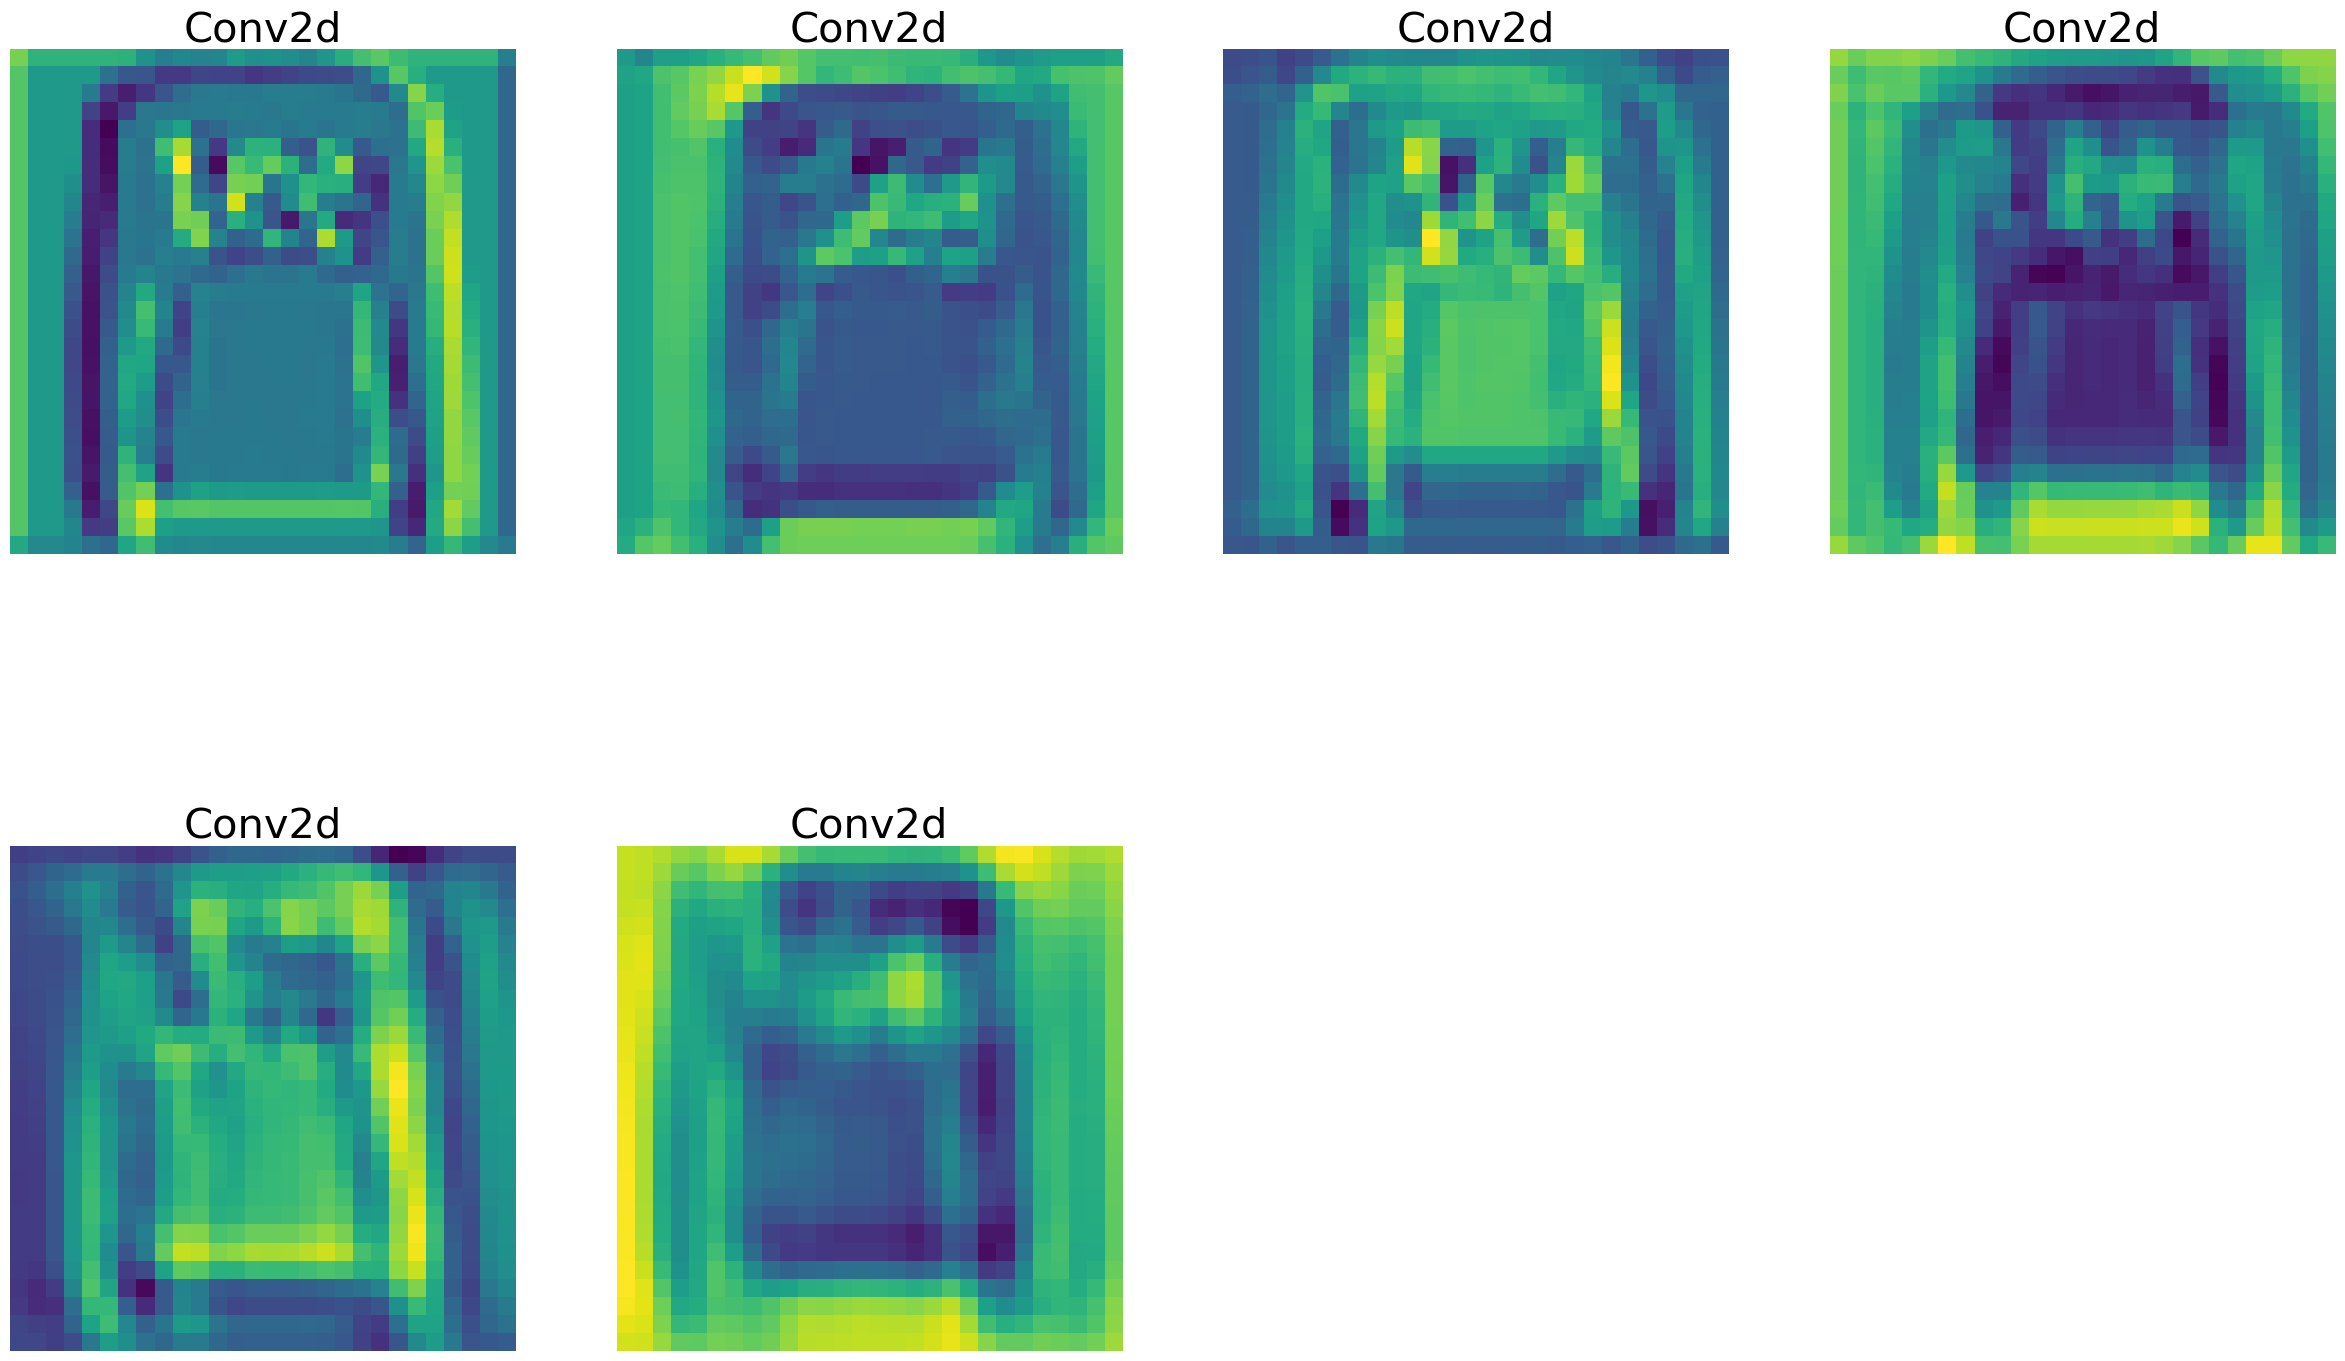

In [24]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)

### **PART B: Transfer Learning**







#### 1. Load a Pretrained model (the simpler the better for computational efficiency e.g.resnet16). You are gonna use it to train your model on Fashion Mnist

In [142]:
import torchvision.transforms as transforms

# Define your transformations
train_transform = transforms.Compose([
    # Convert the PIL Image to a tensor
    transforms.ToTensor(),
    # Duplicate the single grayscale channel to RGB
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
    # Random resize and crop
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), antialias=True),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_transform = transforms.Compose([
    # Convert the PIL Image to a tensor
    transforms.ToTensor(),
    # Duplicate the single grayscale channel to RGB
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
    # Resize to 256x256
    transforms.Resize(256, antialias=True),
    # Center crop to 224x224
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


# Load the complete dataset for training (with transforms) and test
full_train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

# Split the full training dataset into training and validation sets (e.g., 90/10 split)
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Define dataloaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#### 2. Freeze the BackBone of the pretrained model (Convolutions etc) and modify the final fully connected layer/layers that perform classification (make sure the new output dimension matches the number of classes in Fashion Mnist)

In [143]:
from torch.optim import lr_scheduler

mobile_net = torchvision.models.mobilenet_v3_small(weights='IMAGENET1K_V1')

for param in mobile_net.parameters():
    param.requires_grad = False

# Modify the final layer
mobile_net.classifier[3] = nn.Linear(1024, 10)

# print the model
print(mobile_net)

# print total parameters
total_params = sum(p.numel() for p in mobile_net.parameters())
print(f'{total_params:,} total parameters.')

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

#### 3. Train the model on Fashion Mnist for a few epoches and log your train/val loss progress as well as the final model accuracy on the validation set.

In [144]:
results_filename = "results_transfer_learning_.csv"
fields = ['Configuration', 'Phase', 'Epoch', 'Loss', 'Accuracy']
descr = 'MobileNetV3_small'

# open file
file = open(results_filename, mode='w', newline='')
writer = csv.writer(file)

# write header
writer.writerow(fields)

# Train the model
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(mobile_net.classifier[3].parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.5)

best_model = train_model(mobile_net, criterion, optimizer_conv, exp_lr_scheduler, train_loader, val_loader, device, writer=writer, config_description=descr, num_epochs=30)

# close file
file.close()

Epochs: 100%|██████████| 30/30 [3:37:25<00:00, 434.84s/it, Phase=val, Epoch=30, Loss=0.372, Accuracy=0.862]    

Best val Acc: 0.865000


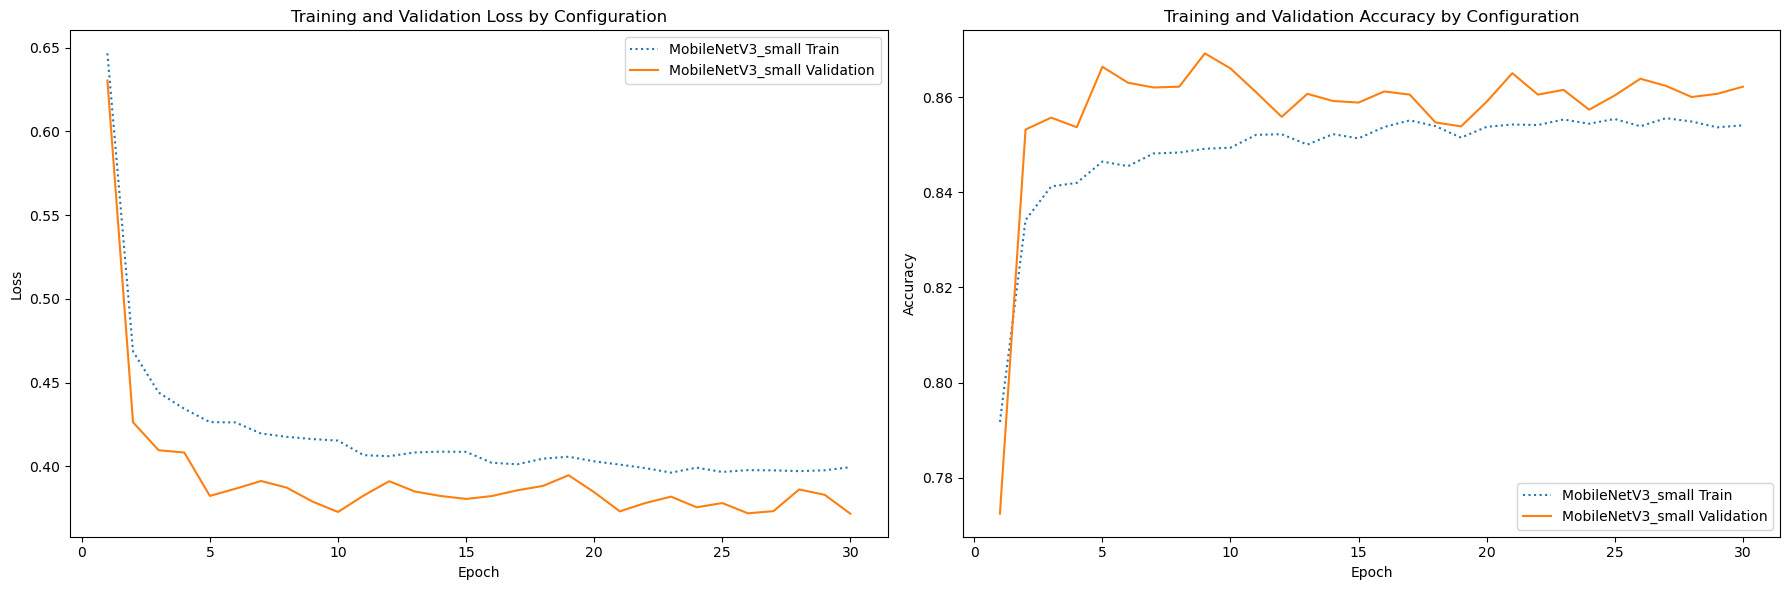

In [31]:
df = pd.read_csv('results/results_transfer_learning.csv')

plot_results(df)

We observe that for the first 5 epochs, the train/validation loss is sharply decreasing. After that, we see a plateau in both losses, indicating that we have settled in a local minimum. This is due to us freezing all the previous layers, and only training the final fully connected that leads to the predictions. 

Gradually unfreezing more and more layers, with a smaller learning rate, would in theory lead to a better model, as the pretrained model will be able to be fine tuned, and the model will be able to capture the features of the Fashion MNIST dataset better.

We should note that, utilizing transfer learning and/or fine tuning, significantly simplifies the process of training a model, at the cost of computational resources since, most of the times, these pretrained models are rather large and require a lot of memory to be stored in the GPU. This extra computation is invaluable when the dataset is small, as training from scratch on few samples is very difficult, but for our moderate sized but simple dataset, we observe that the networks we designed and trained from scratch, had no problem being optimized and score very high accuracies on the test set. 

#### **Optional:** If you are interested you can also unfreeze the final convolutions of the pretrained model to Fine Tune it. You can even visualize the Feature Maps of you model.

#### *Guidelines*: The goal of this assignment is that you play around a little bit with terms and notions introduced. You don' t have to train your models for ages. 5-10 epoches will suffice. We just want to see that you can make a model properly, train it and log some results.